In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

## Carga data

In [128]:
infile = open('cleandata_pickle.pickle','rb')
data_clean = pickle.load(infile)
infile.close()

### Agregar variables temporales

In [129]:
data_clean['dow_creacion'] = data_clean['dttm_creacion'].dt.dayofweek
data_clean['hora_creacion'] = data_clean['dttm_creacion'].dt.hour
data_clean['mes_creacion'] = data_clean['dttm_creacion'].dt.month
data_clean['año_creacion'] = data_clean['dttm_creacion'].dt.year
data_clean['fecha_creacion'] = data_clean['dttm_creacion'].dt.floor('D')
data_clean['dow_cierre'] = data_clean['dttm_cierre'].dt.dayofweek
data_clean['hora_cierre'] = data_clean['dttm_cierre'].dt.hour
data_clean['mes_cierre'] = data_clean['dttm_cierre'].dt.month
data_clean['año_cierre'] = data_clean['dttm_cierre'].dt.year
data_clean['fecha_cierre'] = data_clean['dttm_cierre'].dt.floor('D')

### Agregar geopoint de nuevo

In [130]:
data_clean['geopoint'] = data_clean['longitud'].round(5).astype('string')+','+data_clean['latitud'].round(5).astype('string')

### Cambiar a minúsculas las variables  `string`

In [131]:
data_clean['clas_con_f_alarma'] = data_clean['clas_con_f_alarma'].str.lower().replace(" ", "_", regex = True, inplace=False)
data_clean['tipo_entrada'] = data_clean['tipo_entrada'].str.lower().replace(" ", "_", regex = True, inplace=False).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
data_clean.head()

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,dttm_creacion,...,hora_creacion,mes_creacion,año_creacion,fecha_creacion,dow_cierre,hora_cierre,mes_cierre,año_cierre,fecha_cierre,geopoint
1164271,C4/131231/03508,A,alvaro obregon,lesionado_atropellado,19.33929,-99.25598,urgencias_medicas,llamada_del_066,alvaro obregon,2013-12-31 23:21:38,...,23,12,2013,2013-12-31,2,1,1,2014,2014-01-01,"-99.25598,19.33929"
1164423,C4/131231/02371,N,alvaro obregon,accidente_choque_sin_lesionados,19.37831,-99.20090,emergencia,llamada_del_066,alvaro obregon,2013-12-31 18:21:47,...,18,12,2013,2013-12-31,3,0,1,2014,2014-01-02,"-99.2009,19.37831"
372612,C4/140101/04189,A,alvaro obregon,accidente_choque_con_lesionados,19.36336,-99.19104,urgencias_medicas,llamada_del_066,alvaro obregon,2014-01-01 21:45:43,...,21,1,2014,2014-01-01,2,23,1,2014,2014-01-01,"-99.19104,19.36336"
372622,C4/140101/04201,A,alvaro obregon,accidente_choque_sin_lesionados,19.36348,-99.19145,emergencia,llamada_del_066,alvaro obregon,2014-01-01 21:46:46,...,21,1,2014,2014-01-01,2,21,1,2014,2014-01-01,"-99.19145,19.36348"
372628,C4/140101/01293,A,alvaro obregon,accidente_choque_sin_lesionados,19.38161,-99.20009,emergencia,llamada_del_066,alvaro obregon,2014-01-01 06:50:48,...,6,1,2014,2014-01-01,2,8,1,2014,2014-01-01,"-99.20009,19.38161"


### Agrega columna label. Identifica las llamadas falsas de las verdaderas

Es importante hacer una distinción entre "registros recibidos" e "incidentes reales".

In [132]:
data_clean['label'] = np.where((data_clean['codigo_cierre'] == 'N') | (data_clean['codigo_cierre'] == 'F') ,1,0 )

Corroboramos que la columna label es correcta

In [6]:
data_clean[['label','codigo_cierre']].value_counts()

label  codigo_cierre
0      A                599965
       D                495388
1      N                271600
       F                 10485
0      I                  5096
dtype: int64

## GEDA

### ¿Coincide latitud y longitud con la delegación correspondiente?

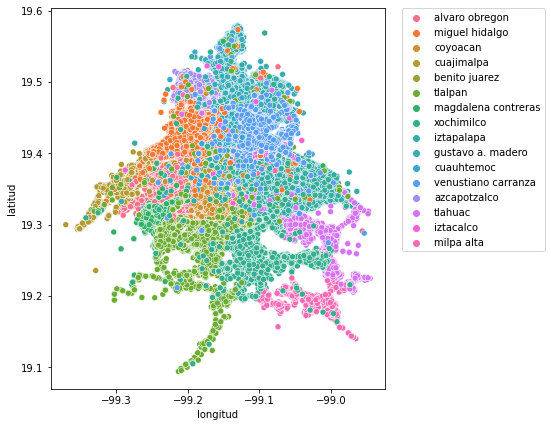

In [78]:
f = plt.subplots(figsize = (6,7))

sns.scatterplot(data = data_clean.drop_duplicates(subset = ['latitud', 'longitud', 'delegacion_inicio']), 
                y = "latitud", x = "longitud", hue = "delegacion_inicio")

ax = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Parece ser que existen varios puntos *fuera de lugar*. Separemos cada delegación para apreciar mejor estos puntos.
De igual manera, veamos qué puntos son los que más se repiten

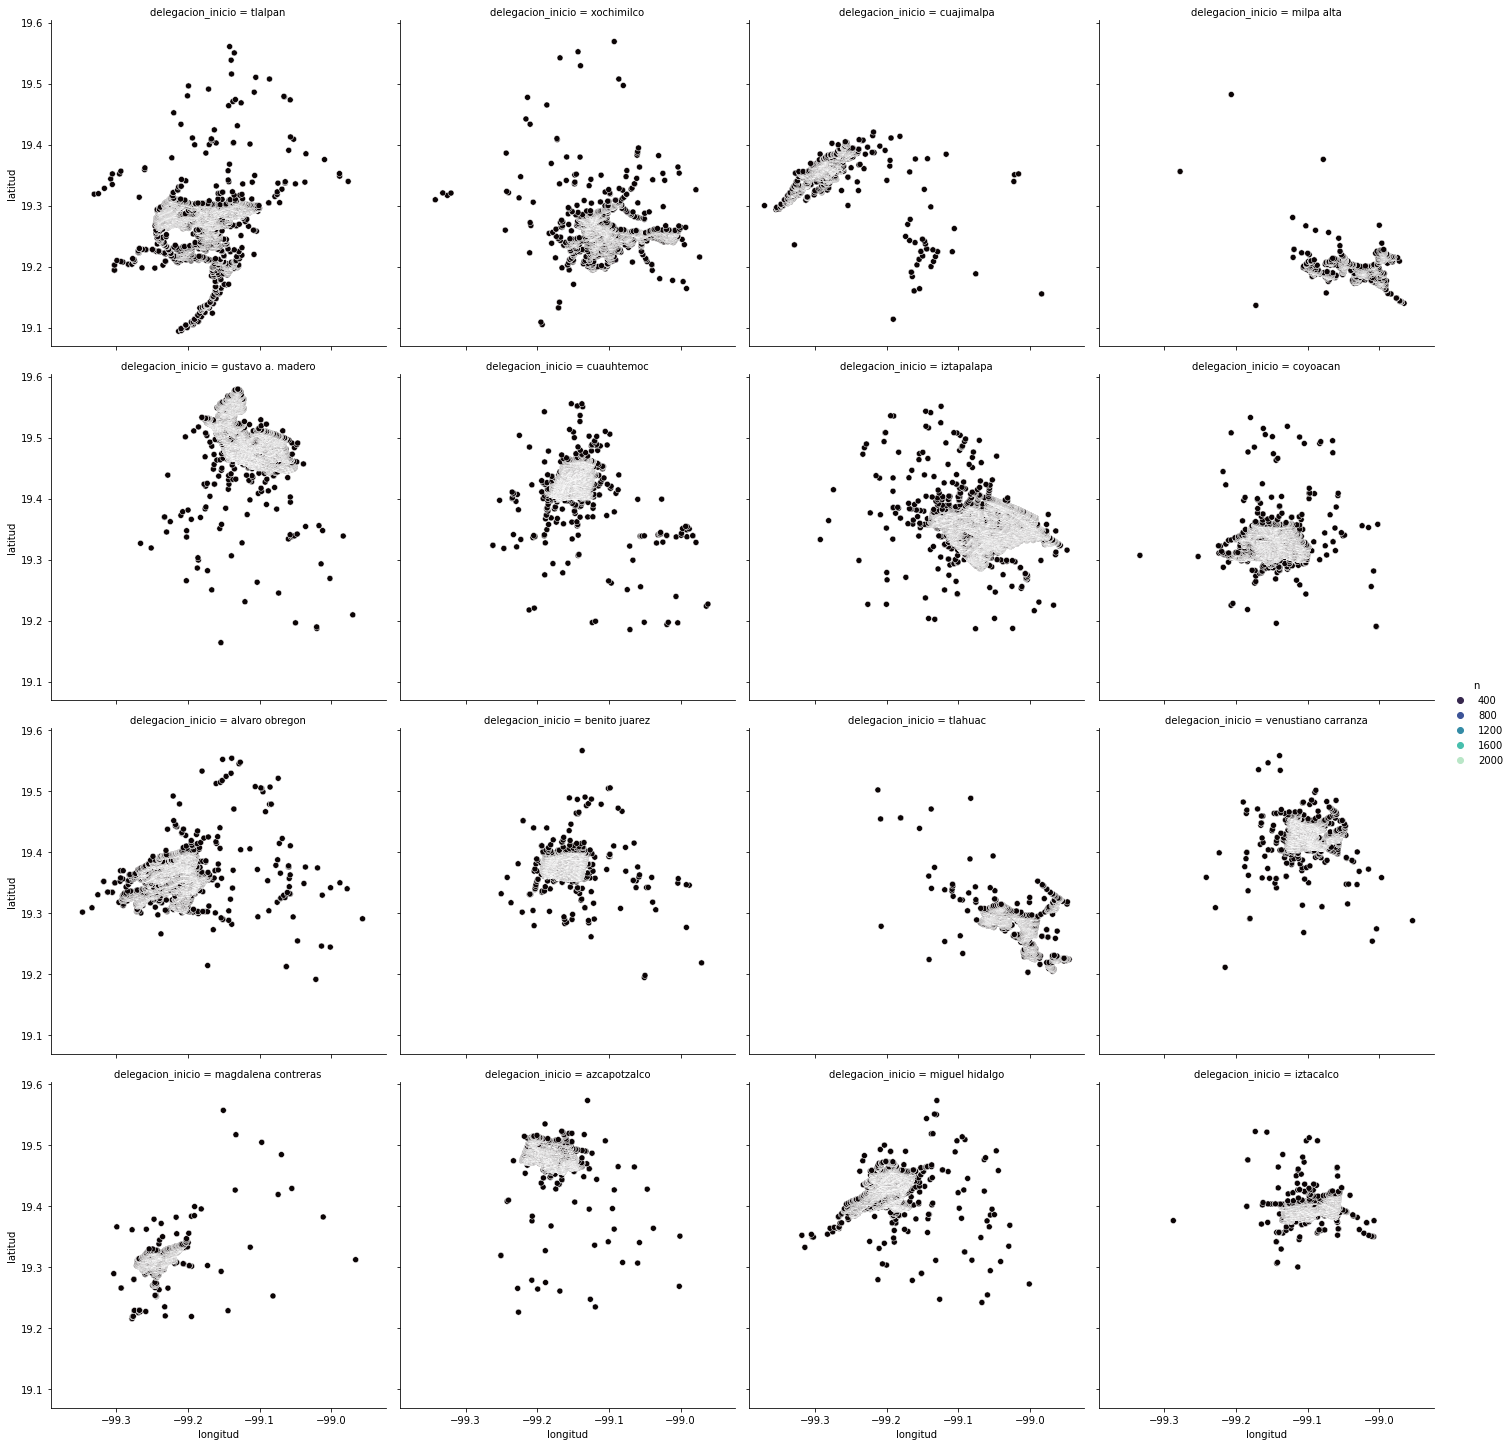

In [124]:
lat_long_deleg_counts = data_clean.groupby(['latitud', 'longitud', 'delegacion_inicio']).size().reset_index(name = 'n')
pal = sns.color_palette("mako", as_cmap=True)
ax = sns.relplot(data = lat_long_deleg_counts, x = 'longitud', y = 'latitud', col = 'delegacion_inicio', hue = 'n', col_wrap = 4, palette= pal)

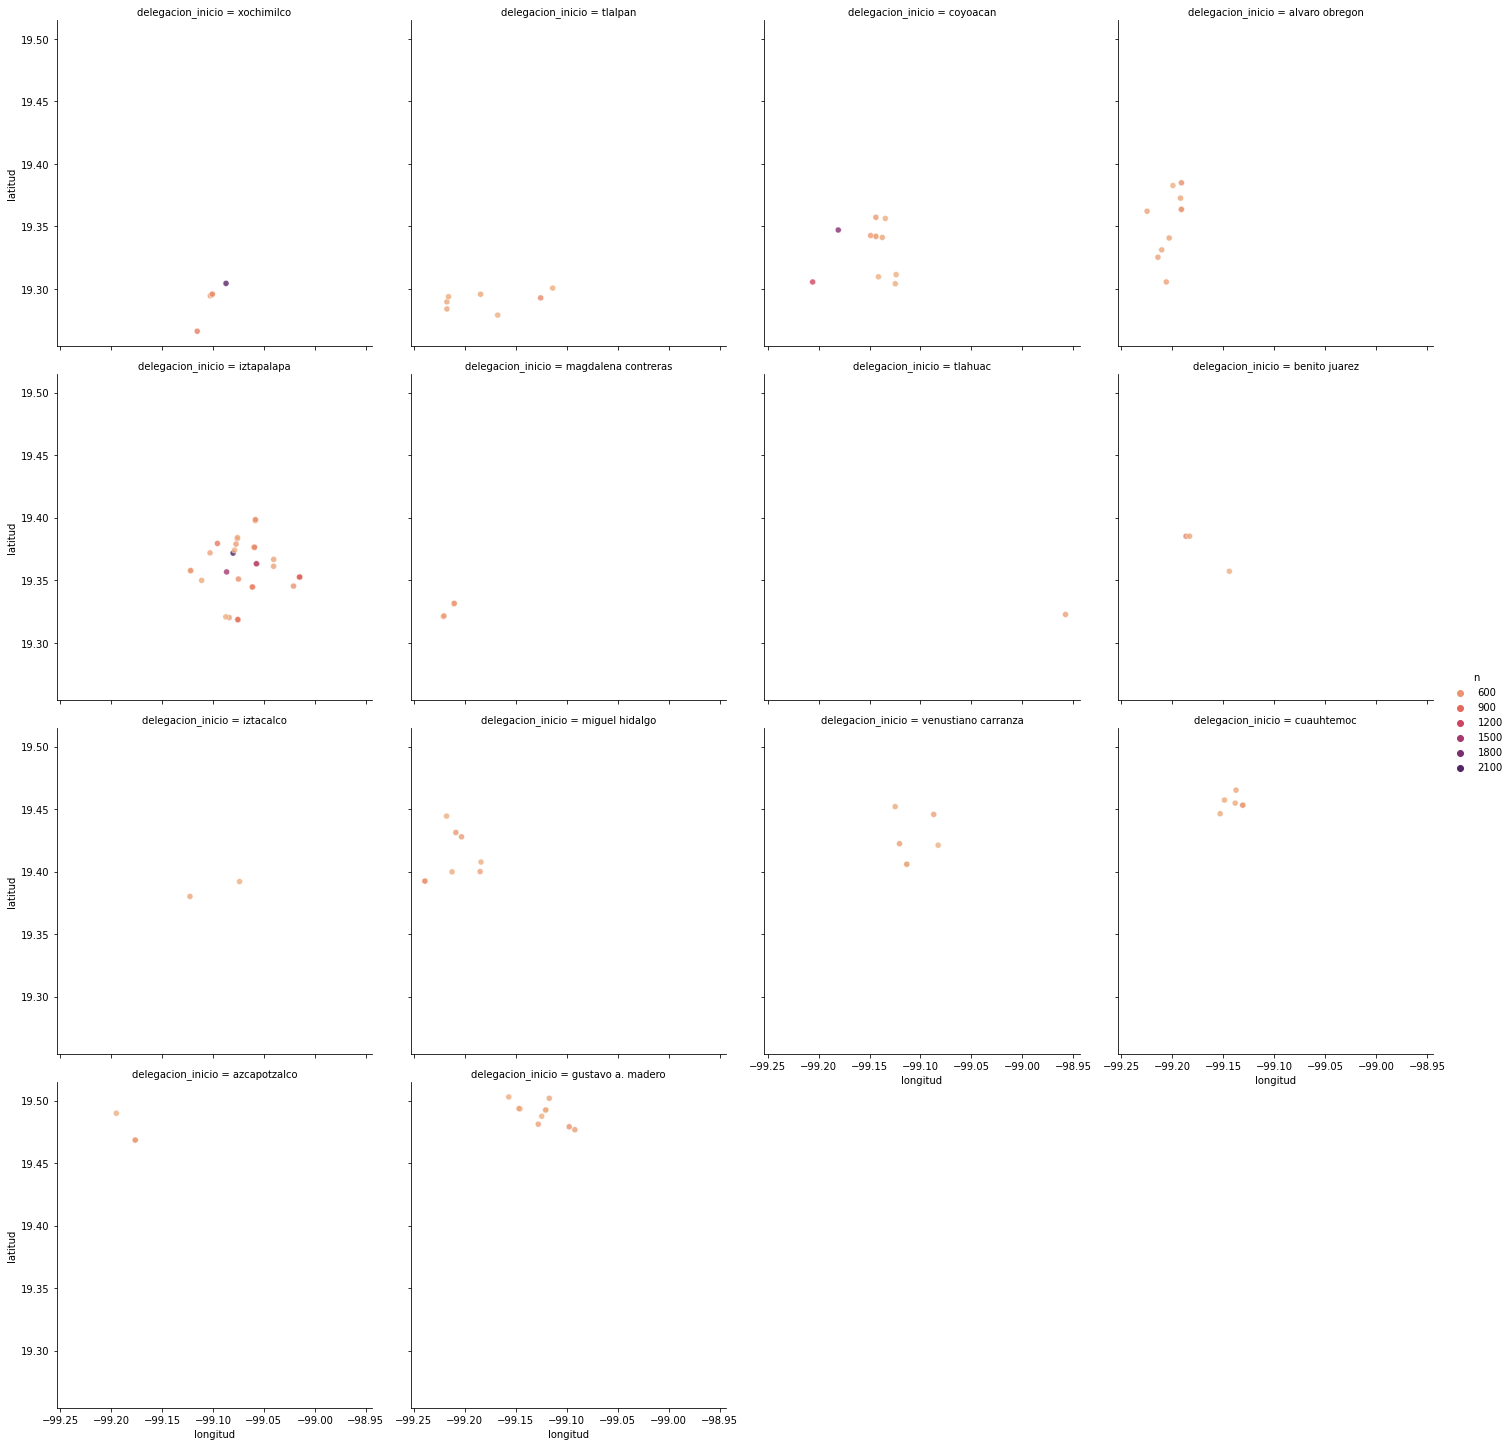

In [127]:
pal = sns.color_palette("flare", as_cmap=True)
ax = sns.relplot(data = lat_long_deleg_counts.query('n > 400'), x = 'longitud', y = 'latitud', col = 'delegacion_inicio', hue = 'n', 
                 col_wrap = 4, palette= pal, alpha = 0.8)

In [77]:
data_clean.drop_duplicates(subset = ['latitud', 'longitud', 'delegacion_inicio'])

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,dttm_creacion,...,mes_creacion,año_creacion,fecha_creacion,dow_cierre,hora_cierre,mes_cierre,año_cierre,fecha_cierre,label,geopoint
1164271,C4/131231/03508,A,alvaro obregon,lesionado_atropellado,19.339290,-99.255980,urgencias_medicas,llamada_del_066,alvaro obregon,2013-12-31 23:21:38.000000000,...,12,2013,2013-12-31,2,1,1,2014,2014-01-01,0,"-99.25598,19.33929"
1164423,C4/131231/02371,N,alvaro obregon,accidente_choque_sin_lesionados,19.378310,-99.200900,emergencia,llamada_del_066,alvaro obregon,2013-12-31 18:21:47.000000000,...,12,2013,2013-12-31,3,0,1,2014,2014-01-02,1,"-99.2009,19.37831"
372612,C4/140101/04189,A,alvaro obregon,accidente_choque_con_lesionados,19.363360,-99.191040,urgencias_medicas,llamada_del_066,alvaro obregon,2014-01-01 21:45:43.000000000,...,1,2014,2014-01-01,2,23,1,2014,2014-01-01,0,"-99.19104,19.36336"
372622,C4/140101/04201,A,alvaro obregon,accidente_choque_sin_lesionados,19.363480,-99.191450,emergencia,llamada_del_066,alvaro obregon,2014-01-01 21:46:46.000000000,...,1,2014,2014-01-01,2,21,1,2014,2014-01-01,0,"-99.19145,19.36348"
372628,C4/140101/01293,A,alvaro obregon,accidente_choque_sin_lesionados,19.381610,-99.200090,emergencia,llamada_del_066,alvaro obregon,2014-01-01 06:50:48.000000000,...,1,2014,2014-01-01,2,8,1,2014,2014-01-01,0,"-99.20009,19.38161"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379538,IZ/201025/06169,A,xochimilco,accidente_motociclista,19.281079,-99.137791,urgencias_medicas,boton_de_auxilio,xochimilco,2020-10-25 17:28:37.000000000,...,10,2020,2020-10-25,6,18,10,2020,2020-10-25,0,"-99.13779,19.28108"
1378036,C5/201026/04782,N,xochimilco,lesionado_atropellado,19.280960,-99.114370,urgencias_medicas,llamada_del_911,xochimilco,2020-10-26 19:54:27.000000000,...,10,2020,2020-10-26,0,20,10,2020,2020-10-26,1,"-99.11437,19.28096"
1378250,C5/201027/01110,D,xochimilco,accidente_volcadura,19.259173,-99.127834,emergencia,radio,xochimilco,2020-10-27 09:16:19.000000000,...,10,2020,2020-10-27,1,16,10,2020,2020-10-27,0,"-99.12783,19.25917"
1378691,C5/201030/05838,N,xochimilco,accidente_choque_sin_lesionados,19.254300,-99.081820,emergencia,llamada_del_911,xochimilco,2020-10-30 21:23:52.999987200,...,10,2020,2020-10-30,4,22,10,2020,2020-10-30,1,"-99.08182,19.2543"


In [96]:
top_geopoints = data_clean[['geopoint']].value_counts().head(16).reset_index(name = 'n').geopoint.values
top_geopoints

array(['-99.08024,19.37168', '-99.08714,19.30432', '-99.18065,19.34702',
       '-99.08656,19.35663', '-99.0574,19.36317', '-99.20581,19.30546',
       '-99.01497,19.35257', '-99.07565,19.31839', '-99.07555,19.31833',
       '-99.09559,19.37941', '-99.11542,19.26606', '-99.10053,19.29578',
       '-99.07551,19.31855', '-99.14592,19.49338', '-99.06129,19.3446',
       '-99.0583,19.39849'], dtype=object)

In [69]:
data_clean[['label','geopoint']].value_counts().reset_index(name = 'n').pivot('geopoint','label', 'n').reset_index().sort_values(by = [1], ascending = False)


label,geopoint,0,1
22273,"-99.08024,19.37168",1628.0,731.0
24877,"-99.08714,19.30432",1676.0,640.0
24631,"-99.08656,19.35663",1103.0,534.0
78895,"-99.18065,19.34702",1274.0,456.0
90822,"-99.20581,19.30546",852.0,406.0
...,...,...,...
106826,"-99.35016,19.29437",1.0,NaN
106827,"-99.35025,19.29429",1.0,NaN
106829,"-99.35121,19.29434",1.0,NaN
106832,"-99.35357,19.29707",1.0,NaN


In [101]:
data_clean[data_clean['geopoint'].isin(top_geopoints)]

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,dttm_creacion,...,mes_creacion,año_creacion,fecha_creacion,dow_cierre,hora_cierre,mes_cierre,año_cierre,fecha_cierre,label,geopoint
1167374,C4/140124/02615,N,alvaro obregon,accidente_choque_sin_lesionados,19.30546,-99.20581,emergencia,llamada_del_066,alvaro obregon,2014-01-24 18:35:51,...,1,2014,2014-01-24,4,20,1,2014,2014-01-24,1,"-99.20581,19.30546"
499156,C4/140131/00203,A,alvaro obregon,lesionado_atropellado,19.30546,-99.20581,urgencias_medicas,llamada_del_066,alvaro obregon,2014-01-31 01:30:00,...,1,2014,2014-01-31,4,1,1,2014,2014-01-31,0,"-99.20581,19.30546"
1026741,C4/140131/00208,A,alvaro obregon,lesionado_atropellado,19.30546,-99.20581,urgencias_medicas,llamada_del_066,alvaro obregon,2014-01-31 01:32:00,...,1,2014,2014-01-31,4,1,1,2014,2014-01-31,0,"-99.20581,19.30546"
499884,C4/140203/01105,A,alvaro obregon,accidente_volcadura,19.30546,-99.20581,emergencia,llamada_del_066,alvaro obregon,2014-02-03 10:06:48,...,2,2014,2014-02-03,0,10,2,2014,2014-02-03,0,"-99.20581,19.30546"
1172365,C4/140205/01012,A,alvaro obregon,accidente_choque_con_lesionados,19.30546,-99.20581,urgencias_medicas,llamada_del_066,alvaro obregon,2014-02-05 11:12:52,...,2,2014,2014-02-05,2,13,2,2014,2014-02-05,0,"-99.20581,19.30546"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380808,C5/201020/04984,N,xochimilco,accidente_choque_sin_lesionados,19.26606,-99.11542,emergencia,llamada_del_911,xochimilco,2020-10-20 20:48:18,...,10,2020,2020-10-20,1,21,10,2020,2020-10-20,1,"-99.11542,19.26606"
1380813,C5/201021/05547,D,xochimilco,accidente_choque_sin_lesionados,19.30432,-99.08714,emergencia,llamada_del_911,xochimilco,2020-10-21 22:35:02,...,10,2020,2020-10-21,2,22,10,2020,2020-10-21,0,"-99.08714,19.30432"
1380894,C5/201021/05558,D,xochimilco,accidente_choque_sin_lesionados,19.30432,-99.08714,emergencia,llamada_del_911,xochimilco,2020-10-21 22:39:34,...,10,2020,2020-10-21,2,23,10,2020,2020-10-21,0,"-99.08714,19.30432"
1381370,C5/201024/00369,A,xochimilco,accidente_choque_con_lesionados,19.26606,-99.11542,urgencias_medicas,radio,xochimilco,2020-10-24 00:45:07,...,10,2020,2020-10-24,5,4,10,2020,2020-10-24,0,"-99.11542,19.26606"


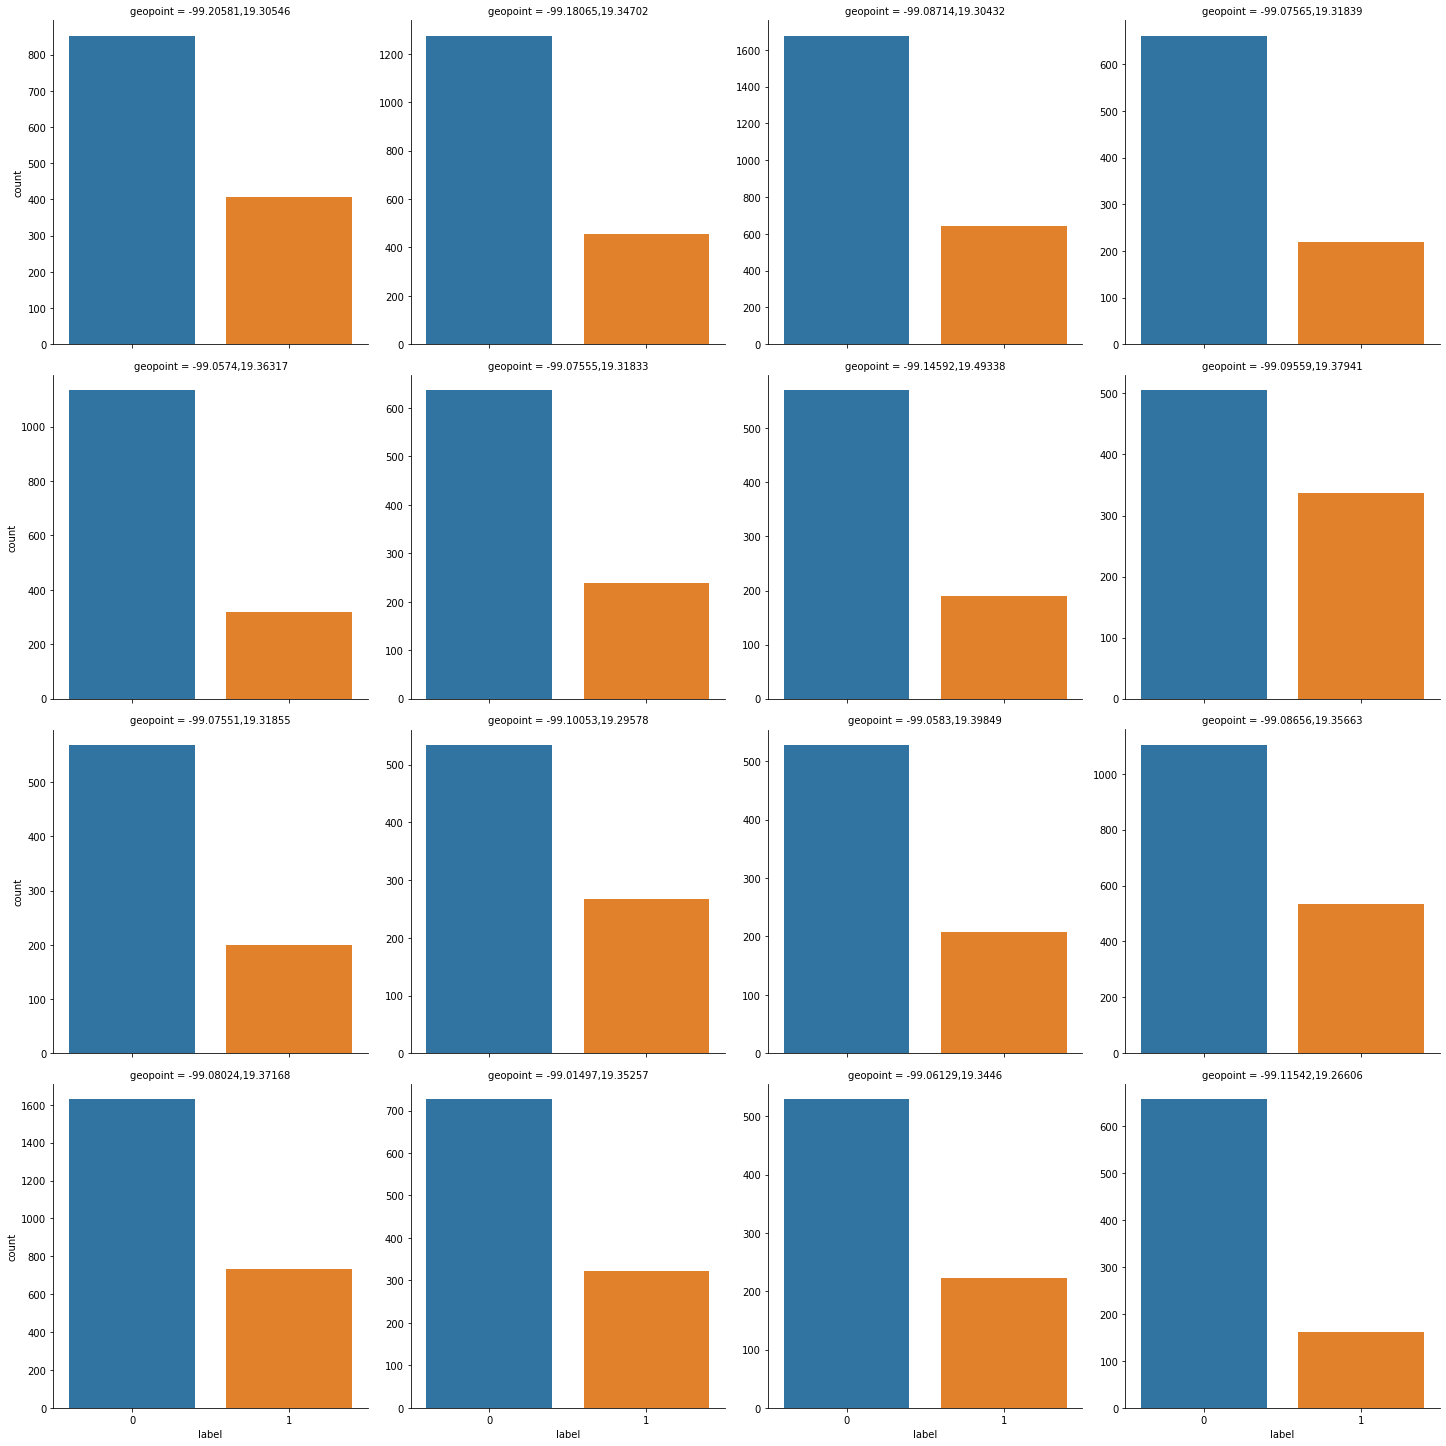

In [102]:
ax = sns.catplot(data = data_clean[data_clean['geopoint'].isin(top_geopoints)],
                 x = 'label', kind = 'count', col = 'geopoint', col_wrap= 4, sharey = False)

### Llamadas por día de la semana y hora de creación

In [8]:
dow_x_hora_creacion = data_clean[['dow_creacion', 'hora_creacion']].groupby(['dow_creacion', 'hora_creacion']).\
size().reset_index(name='n').pivot("hora_creacion", "dow_creacion","n")

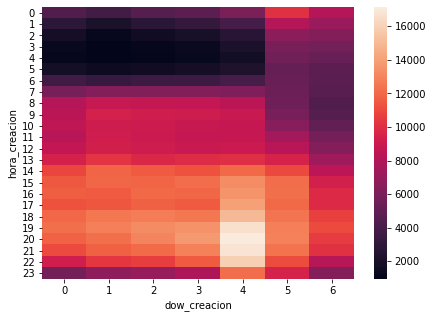

In [9]:
f = plt.subplots(figsize = (7,5))
ax = sns.heatmap(dow_x_hora_creacion)

### Llamadas por día de la semana y mes de creación

Cuando más llamadas hay es los viernes entre 18 y 22 hrs. Cuando menos llamadas hay es de lunes a viernes de 12am a 6am

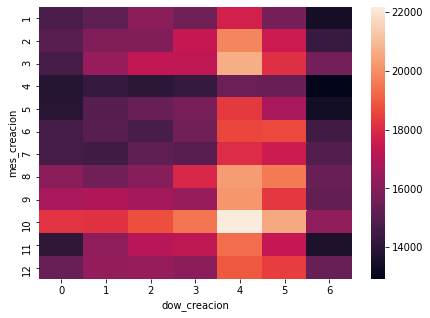

In [10]:
dow_x_mes_creacion = data_clean[['dow_creacion', 'mes_creacion']].groupby(['dow_creacion', 'mes_creacion']).\
size().reset_index(name='n').pivot("mes_creacion", "dow_creacion","n")

f = plt.subplots(figsize = (7,5))
ax = sns.heatmap(dow_x_mes_creacion)

### Llamadas por año y mes de creación

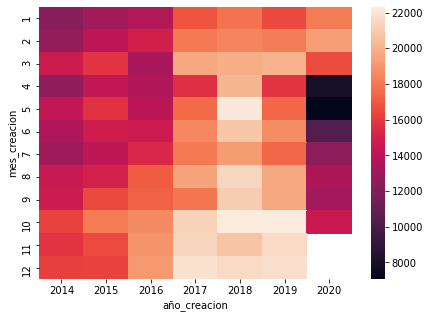

In [11]:
año_x_mes_creacion = data_clean[['año_creacion', 'mes_creacion']].groupby(['año_creacion', 'mes_creacion']).\
size().reset_index(name='n').query('año_creacion != 2013').pivot("mes_creacion", "año_creacion","n")

f = plt.subplots(figsize = (7,5))
ax = sns.heatmap(año_x_mes_creacion)

### Llamadas por delegación

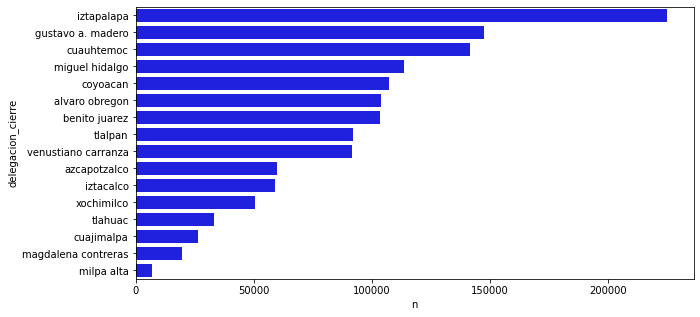

In [12]:
llamadas_x_deleg = data_clean.groupby(['delegacion_cierre']).size().reset_index(name = "n").sort_values("n", ascending = False)

f = plt.subplots(figsize = (10,5))
ax = sns.barplot(data = llamadas_x_deleg, x = 'n', y = 'delegacion_cierre', color= 'b')

In [13]:
orden_delegaciones=['iztapalapa', 'gustavo a. madero', 'cuauhtemoc', 'miguel hidalgo', 'coyoacan', 'alvaro obregon', 'benito juarez',\
                    'tlalpan', 'venustiano carranza', 'azcapotzalco','iztacalco', 'xochimilco', 'tlahuac', 'cuajimalpa', 'magdalena contreras', 'milpa alta']

### Llamadas por año

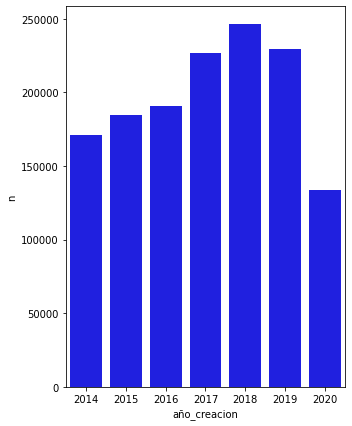

In [14]:
llamadas_x_año = data_clean.query('año_creacion != 2013').groupby(['año_creacion']).size().reset_index(name = "n").sort_values("n", ascending = False)
llamadas_x_año['año_creacion'] = llamadas_x_año['año_creacion'].astype("object")

f = plt.subplots(figsize = (5,7))
ax = sns.barplot(data = llamadas_x_año, y = 'n', x = 'año_creacion', color= 'b')

### Serie de tiempo llamadas

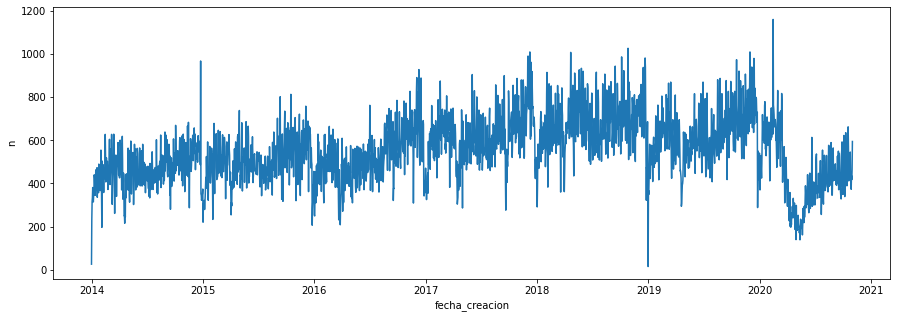

In [15]:
llamadas_diarias = data_clean.groupby(['fecha_creacion']).size().reset_index(name = "n")
f = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data = llamadas_diarias, x = 'fecha_creacion', y = 'n')

### Serie de tiempo de llamadas por codigo_cierre

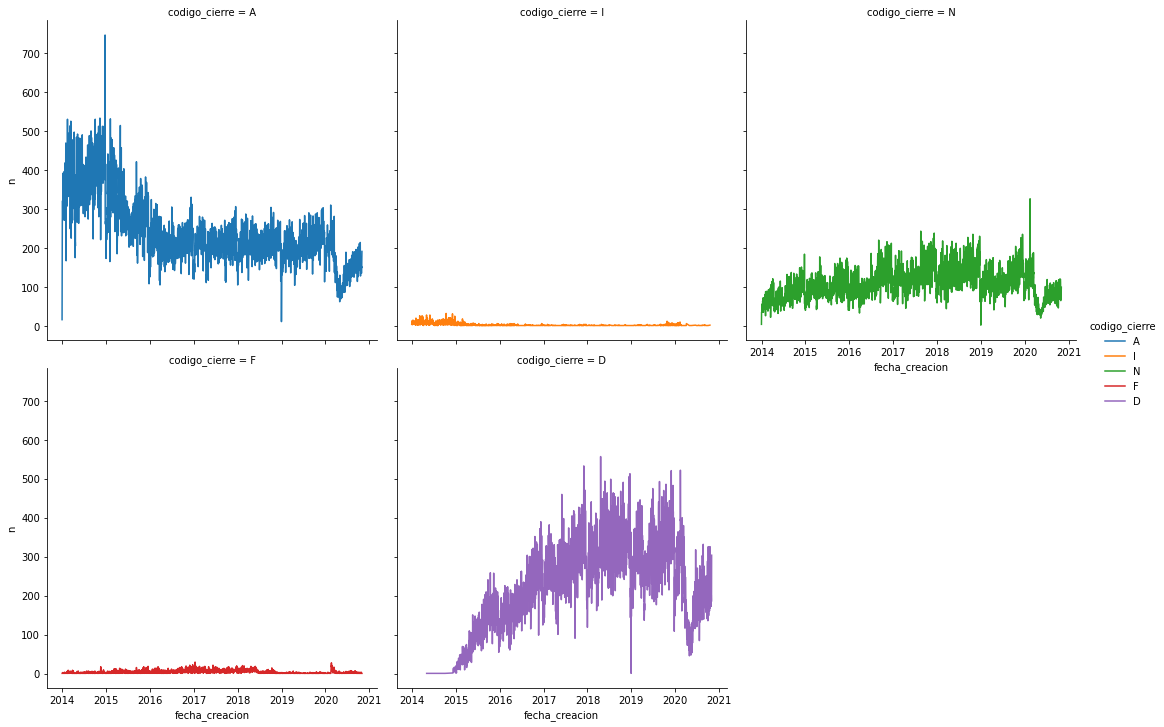

In [16]:
llamadas_diarias_codigo = data_clean.groupby(['fecha_creacion', 'codigo_cierre']).size().reset_index(name = "n")
llamadas_diarias_codigo

#f = plt.subplots(figsize = (15,5))
ax = sns.relplot(data = llamadas_diarias_codigo, x = 'fecha_creacion', y = 'n', hue = 'codigo_cierre', col = 'codigo_cierre', kind = 'line', col_wrap = 3)

### Llamadas según codigo_cierre

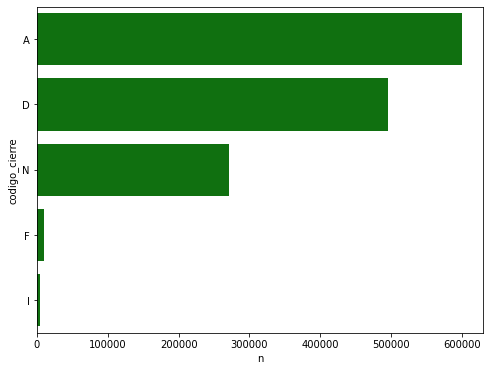

In [17]:
llamadas_x_codigo_cierre = data_clean.groupby(['codigo_cierre']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (8,6))
ax = sns.barplot(data = llamadas_x_codigo_cierre, x = 'n', y = 'codigo_cierre', color= 'g')

## Utilizando únicamente los incidentes 

### Serie de tiempo de llamadas según label

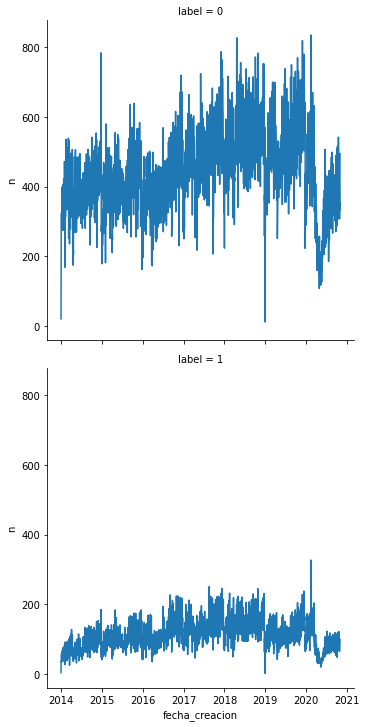

In [18]:
llamadas_diarias_label = data_clean.groupby(['fecha_creacion', 'label']).size().reset_index(name = "n")

#f = plt.subplots(figsize = (15,5))
ax = sns.relplot(data = llamadas_diarias_label, x = 'fecha_creacion', y = 'n', col = 'label', kind = 'line', col_wrap = 1)

### Incidente C4

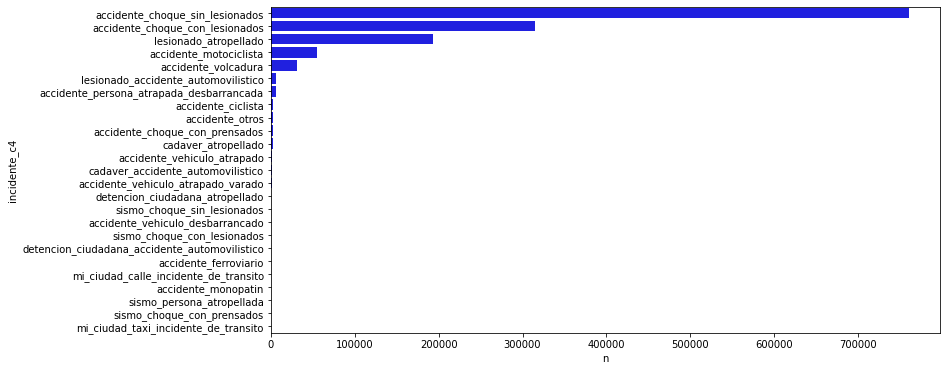

In [19]:
llamadas_x_incidente = data_clean.groupby(['incidente_c4']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (12,6))
ax = sns.barplot(data = llamadas_x_incidente, x = 'n', y = 'incidente_c4', color= 'b')

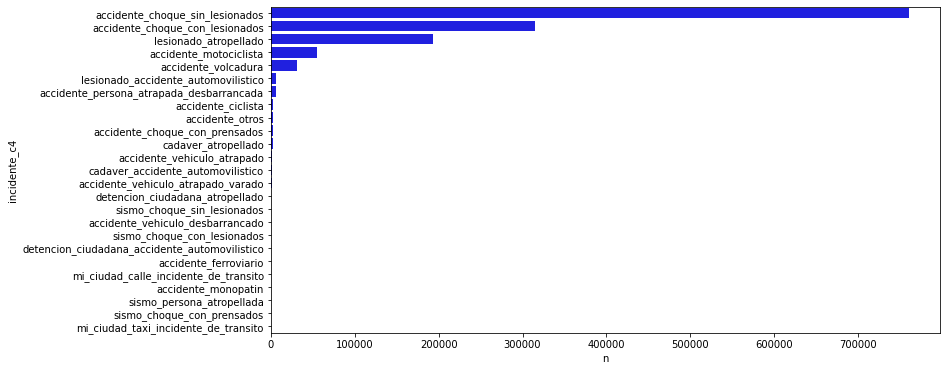

In [20]:
llamadas_x_incidente = data_clean.groupby(['incidente_c4']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (12,6))
ax = sns.barplot(data = llamadas_x_incidente, x = 'n', y = 'incidente_c4', color= 'b')

### Incidentes según tipo_entrada

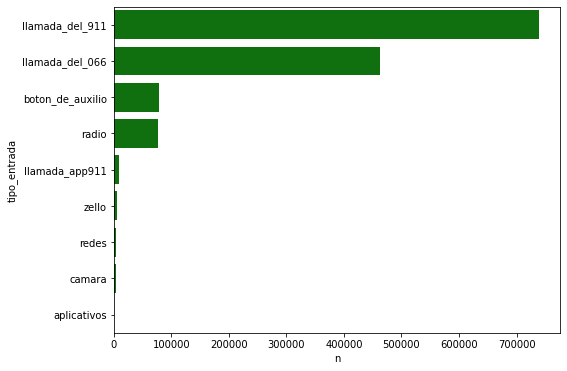

In [21]:
llamadas_x_tipo_entrada = data_clean.groupby(['tipo_entrada']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (8,6))
ax = sns.barplot(data = llamadas_x_tipo_entrada, x = 'n', y = 'tipo_entrada', color= 'g')

In [22]:
orden_entradas = ['llamada_del_911', 'llamada_del_066', 'radio', 'boton_de_auxilio', 'llamada_app911', 'redes', 'zello', 'camara', 'aplicativos']

### Clasificación de la llamada

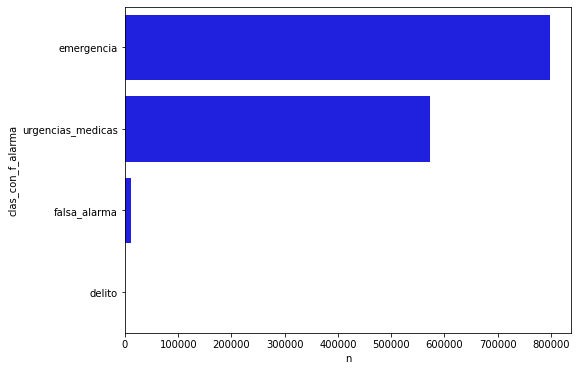

In [23]:
llamadas_x_clas = data_clean.groupby(['clas_con_f_alarma']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (8,6))
ax = sns.barplot(data = llamadas_x_clas, x = 'n', y = 'clas_con_f_alarma', color= 'b')

### Incidentes por codigo_cierre y clasificacion

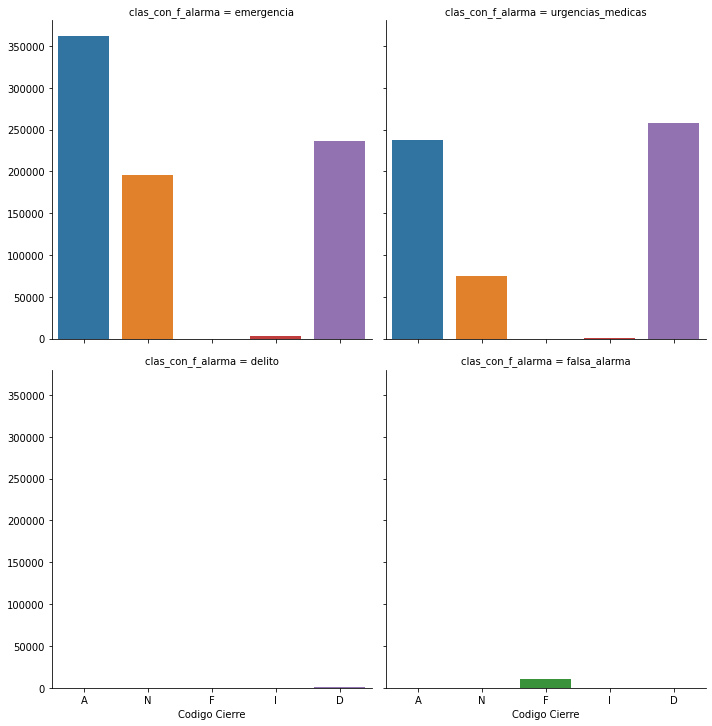

In [24]:
ax = sns.catplot(data = data_clean, x = 'codigo_cierre', col = 'clas_con_f_alarma', kind = 'count' , sharey = True, col_wrap = 2,
                 col_order = ['emergencia', 'urgencias_medicas', 'delito', 'falsa_alarma'])
(ax.set_axis_labels("Codigo Cierre", ""))

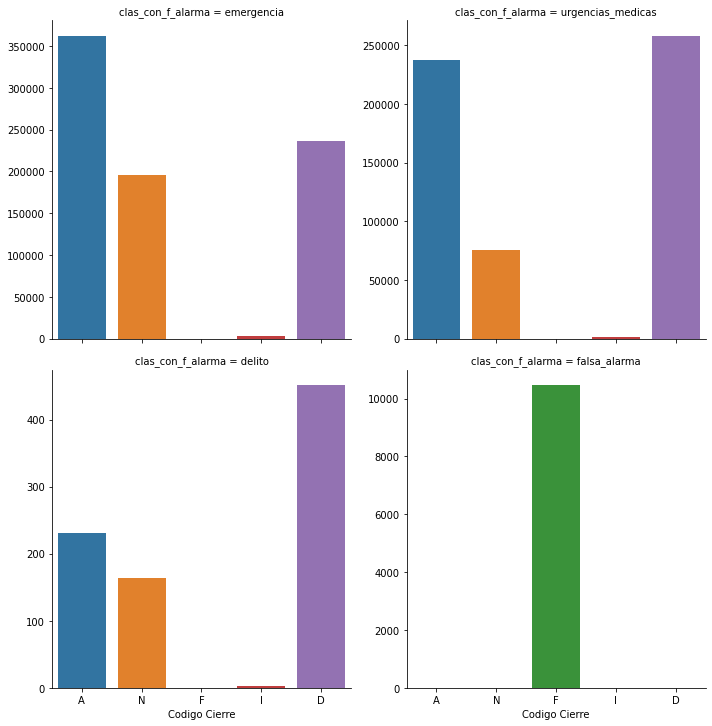

In [25]:
ax = sns.catplot(data = data_clean, x = 'codigo_cierre', col = 'clas_con_f_alarma', kind = 'count' , sharey = False,col_wrap = 2,
                 col_order = ['emergencia', 'urgencias_medicas', 'delito', 'falsa_alarma'])
(ax.set_axis_labels("Codigo Cierre", ""))

Se observa que, en su mayoría, la etiqueta FALSA ALARMA de la columna `clas_con_f_alarma` sí coincide con el valor F de `codigo_cierre`

Es importante notar que no se cuenta con la variable `clas_con_f_alarma` al momento de recibir una llamada, por lo que esta variable no es útil para predecir `label`

## Predicción de Label

Observemos las proporciones de label a lo largo de cada nivel de algunas variables

### Delegación

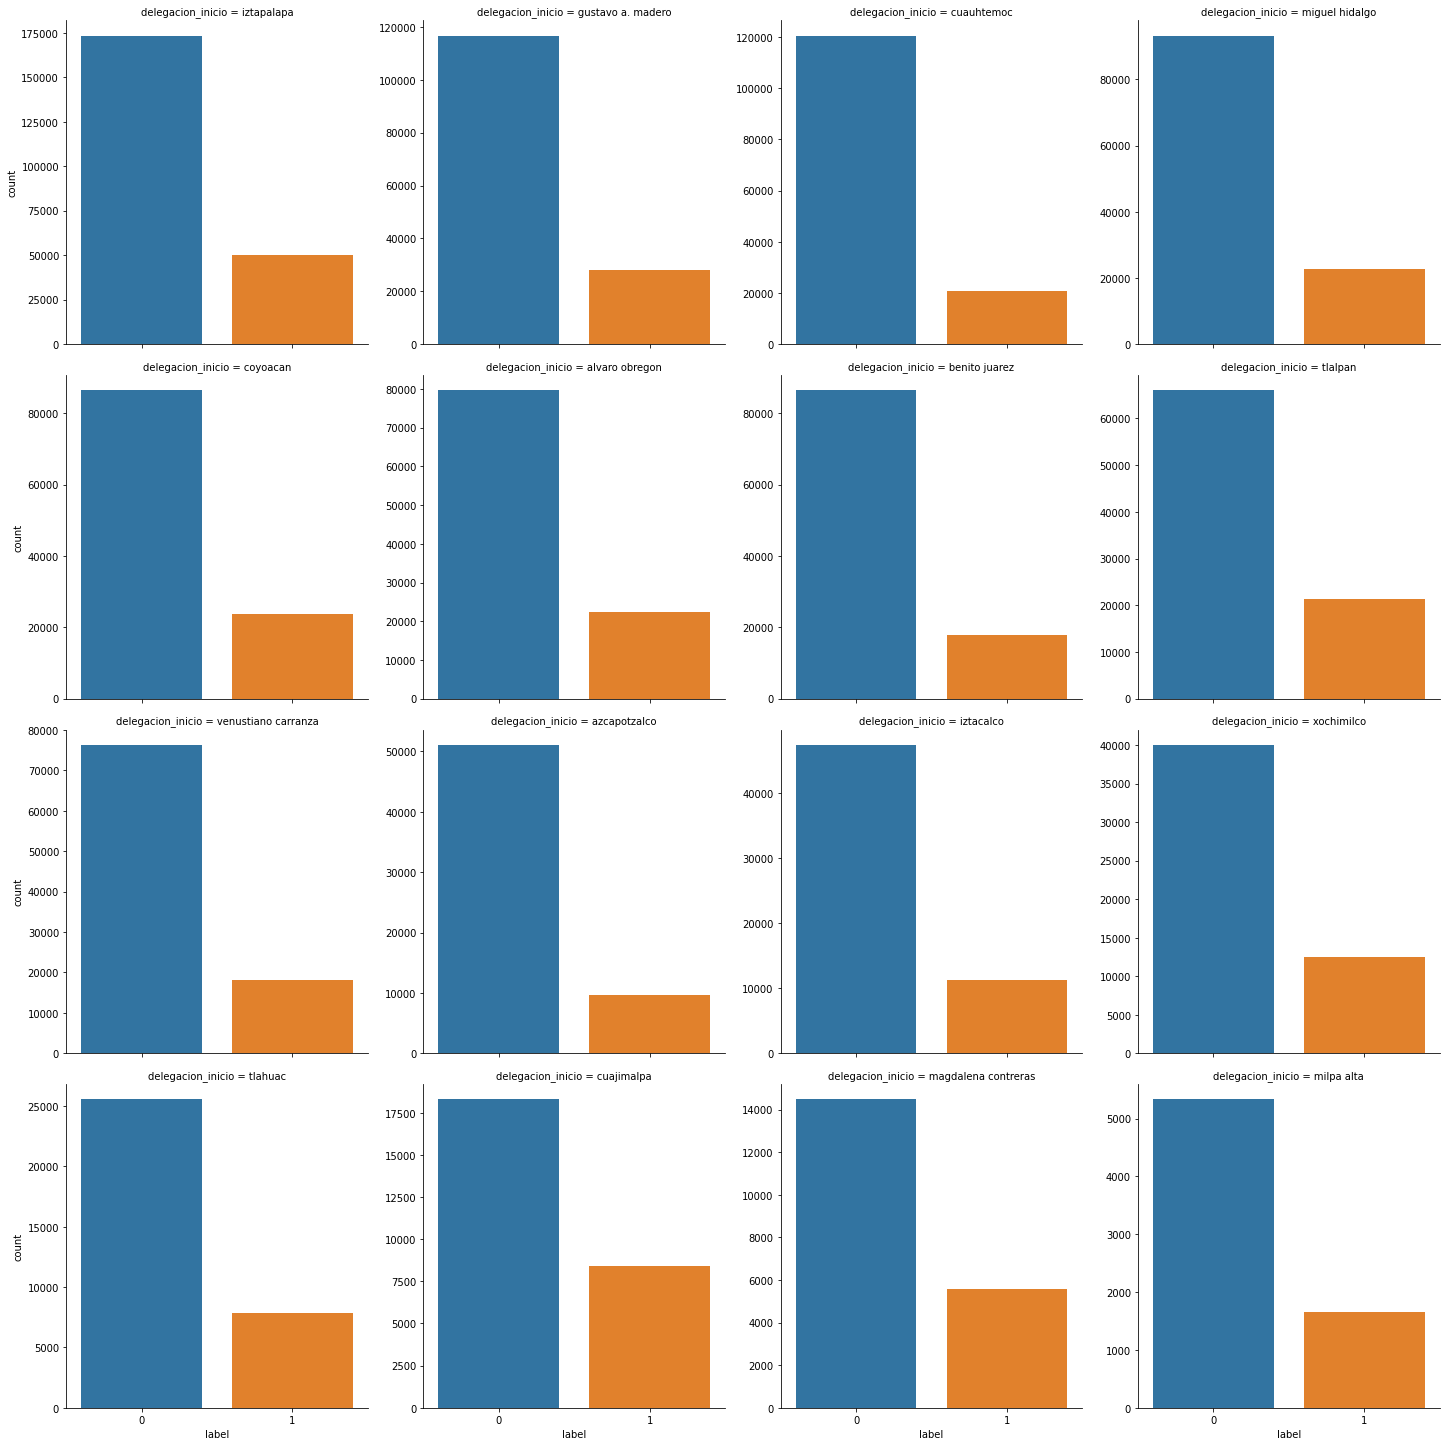

In [26]:
ax = sns.catplot(data = data_clean, x = 'label', kind = 'count', col = 'delegacion_inicio', col_wrap= 4, sharey = False,
                col_order = orden_delegaciones )

Vemos que en Cuajimalpa hay un alta proporción de llamadas falsas, mientras que en cuauhtemoc, benito juarez y azcapotzalco hay una proporción mas baja.

### Tipo de entrada

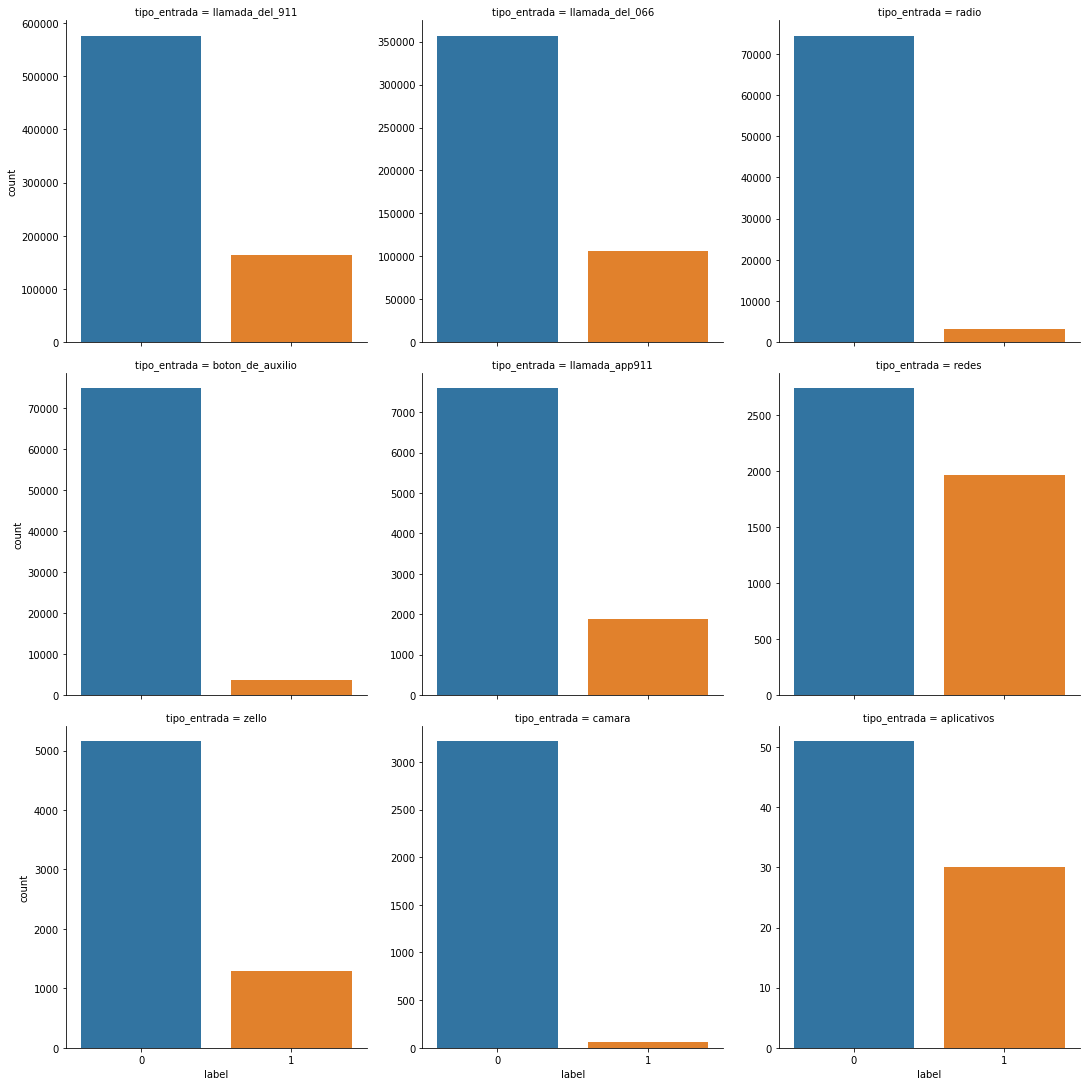

In [27]:
ax = sns.catplot(data = data_clean, x = 'label', kind = 'count', col = 'tipo_entrada', col_wrap= 3, sharey = False,
                 col_order = orden_entradas)

Vemos que las entradas por radio tienen proporciones muy bajas de Falsas Alarmas, mientras que redes y aplicativos tienen las propociones más altas

### Dia de la semana en el que se recibe la llamada

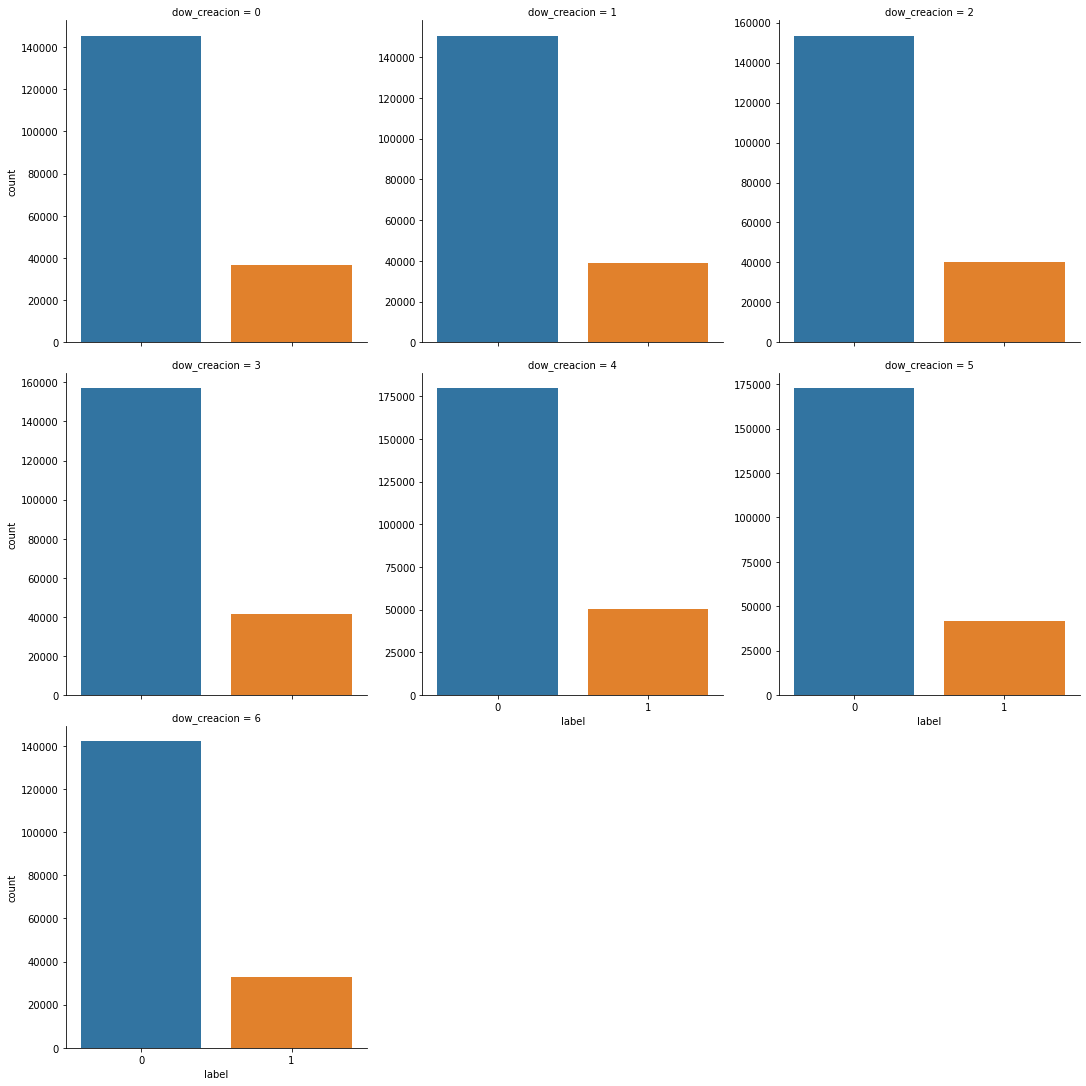

In [28]:
ax = sns.catplot(data = data_clean, x = 'label', kind = 'count', col = 'dow_creacion', col_wrap= 3, sharey = False)

En general, no hay mucha diferencia en la proporción de llamadas falsas según el dia de la semana

### Mes creación

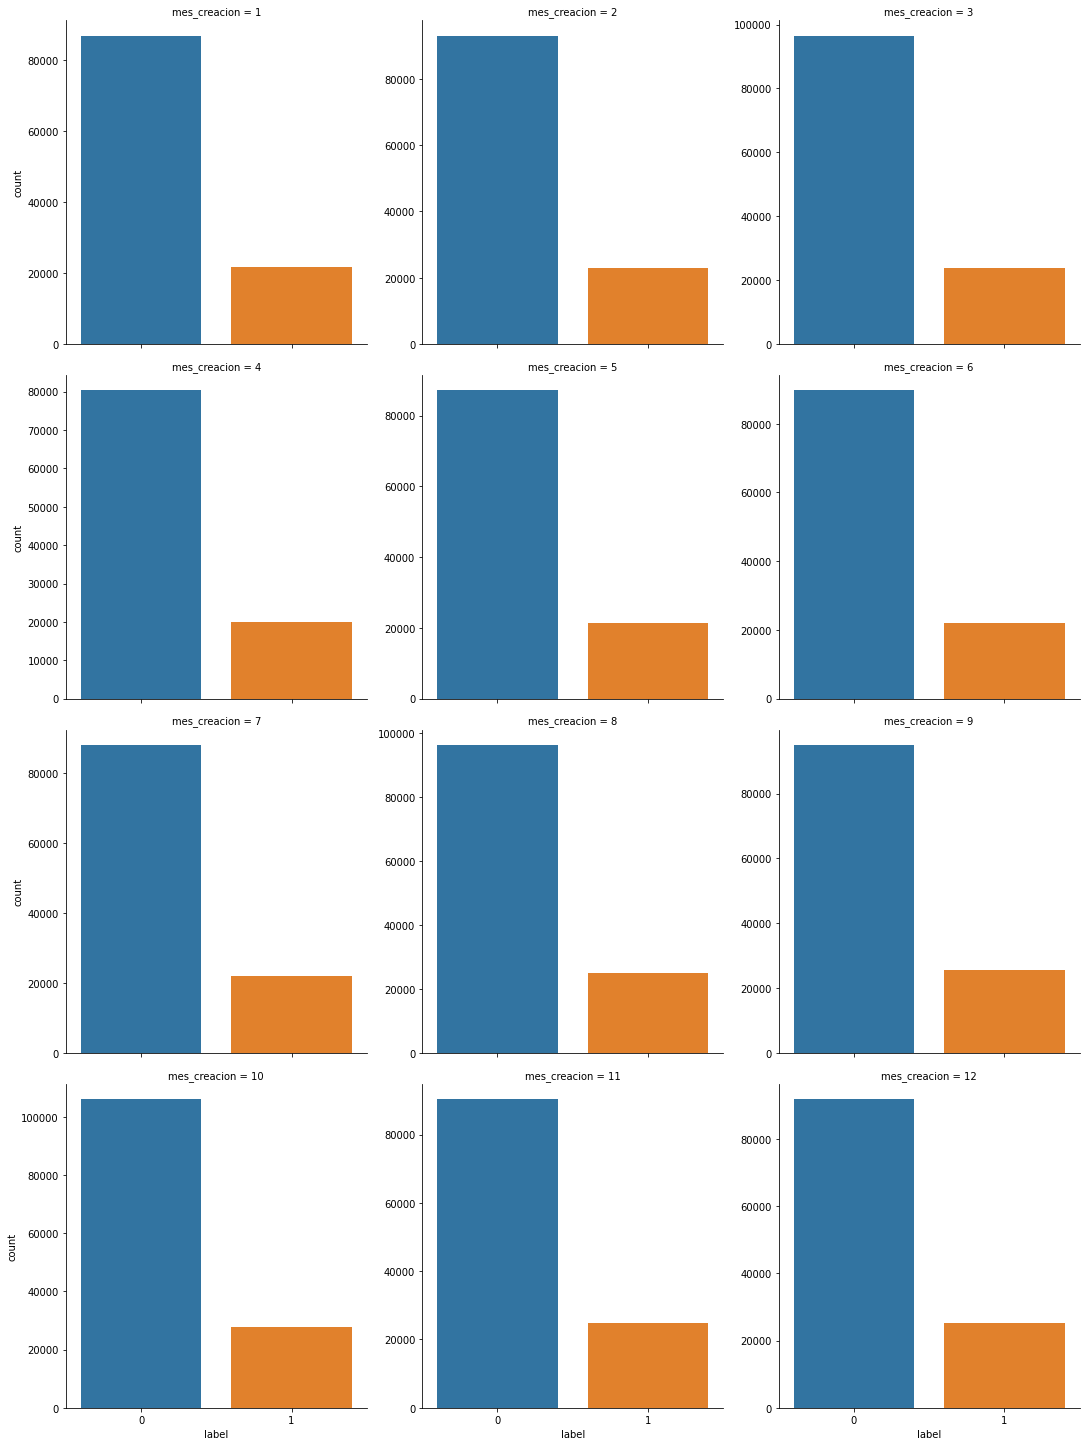

In [29]:
ax = sns.catplot(data = data_clean, x = 'label', kind = 'count', col = 'mes_creacion', col_wrap= 3, sharey = False)

Al igual que por día de la semana, no se observan diferencias considerables en la proporción de llamadas falsas según el mes en las que se recibe la llamada

## Data para RF

In [133]:
data_clean.drop(columns= ['folio', 'codigo_cierre', ])

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,dttm_creacion,...,mes_creacion,año_creacion,fecha_creacion,dow_cierre,hora_cierre,mes_cierre,año_cierre,fecha_cierre,geopoint,label
1164271,C4/131231/03508,A,alvaro obregon,lesionado_atropellado,19.339290,-99.255980,urgencias_medicas,llamada_del_066,alvaro obregon,2013-12-31 23:21:38,...,12,2013,2013-12-31,2,1,1,2014,2014-01-01,"-99.25598,19.33929",0
1164423,C4/131231/02371,N,alvaro obregon,accidente_choque_sin_lesionados,19.378310,-99.200900,emergencia,llamada_del_066,alvaro obregon,2013-12-31 18:21:47,...,12,2013,2013-12-31,3,0,1,2014,2014-01-02,"-99.2009,19.37831",1
372612,C4/140101/04189,A,alvaro obregon,accidente_choque_con_lesionados,19.363360,-99.191040,urgencias_medicas,llamada_del_066,alvaro obregon,2014-01-01 21:45:43,...,1,2014,2014-01-01,2,23,1,2014,2014-01-01,"-99.19104,19.36336",0
372622,C4/140101/04201,A,alvaro obregon,accidente_choque_sin_lesionados,19.363480,-99.191450,emergencia,llamada_del_066,alvaro obregon,2014-01-01 21:46:46,...,1,2014,2014-01-01,2,21,1,2014,2014-01-01,"-99.19145,19.36348",0
372628,C4/140101/01293,A,alvaro obregon,accidente_choque_sin_lesionados,19.381610,-99.200090,emergencia,llamada_del_066,alvaro obregon,2014-01-01 06:50:48,...,1,2014,2014-01-01,2,8,1,2014,2014-01-01,"-99.20009,19.38161",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380319,C5/201031/02258,A,xochimilco,accidente_choque_sin_lesionados,19.283730,-99.129490,emergencia,llamada_del_911,xochimilco,2020-10-31 06:51:39,...,10,2020,2020-10-31,5,9,10,2020,2020-10-31,"-99.12949,19.28373",0
1382406,C5/201031/08062,D,xochimilco,accidente_choque_sin_lesionados,19.294470,-99.102490,emergencia,llamada_del_911,xochimilco,2020-10-31 21:29:11,...,10,2020,2020-10-31,5,21,10,2020,2020-10-31,"-99.10249,19.29447",0
1382445,C5/201031/07490,N,xochimilco,accidente_choque_con_lesionados,19.210047,-99.132963,urgencias_medicas,llamada_del_911,xochimilco,2020-10-31 20:41:36,...,10,2020,2020-10-31,5,22,10,2020,2020-10-31,"-99.13296,19.21005",1
1382469,C5/201031/02358,D,xochimilco,accidente_choque_con_lesionados,19.283730,-99.129490,urgencias_medicas,llamada_del_911,xochimilco,2020-10-31 07:23:34,...,10,2020,2020-10-31,5,7,10,2020,2020-10-31,"-99.12949,19.28373",0


In [142]:
data_rf = data_clean.loc[:,~data_clean.columns.str.contains('_cierre')]

data_rf = data_rf.drop(columns = ['folio', 'clas_con_f_alarma', 'latitud', 'longitud', 'dttm_creacion', 'fecha_creacion', 'año_creacion'])

data_rf

,delegacion_inicio,incidente_c4,tipo_entrada,dow_creacion,hora_creacion,mes_creacion,geopoint,label
1164271,alvaro obregon,lesionado_atropellado,llamada_del_066,1,23,12,"-99.25598,19.33929",0
1164423,alvaro obregon,accidente_choque_sin_lesionados,llamada_del_066,1,18,12,"-99.2009,19.37831",1
372612,alvaro obregon,accidente_choque_con_lesionados,llamada_del_066,2,21,1,"-99.19104,19.36336",0
372622,alvaro obregon,accidente_choque_sin_lesionados,llamada_del_066,2,21,1,"-99.19145,19.36348",0
372628,alvaro obregon,accidente_choque_sin_lesionados,llamada_del_066,2,6,1,"-99.20009,19.38161",0
...,...,...,...,...,...,...,...,...
1380319,xochimilco,accidente_choque_sin_lesionados,llamada_del_911,5,6,10,"-99.12949,19.28373",0
1382406,xochimilco,accidente_choque_sin_lesionados,llamada_del_911,5,21,10,"-99.10249,19.29447",0
1382445,xochimilco,accidente_choque_con_lesionados,llamada_del_911,5,20,10,"-99.13296,19.21005",1
1382469,xochimilco,accidente_choque_con_lesionados,llamada_del_911,5,7,10,"-99.12949,19.28373",0


In [143]:
outfile = open('data_rf.pickle','wb')
pickle.dump(data_rf,outfile)

outfile.close()